In [4]:
# importer le notebook des fonctions utiles et des importations nécessaires
import nbimporter
from functions_and_imports import *

data = pd.read_csv('data/df_12H_imputed_with_knn.csv')
display_basic_info(data)

In [ ]:
# split
train_df, test_df = split_train_test_data_v2(data)

# Extraction de séquences et normalisation
normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, scaler = extract_sequences_and_normalize(train_df, test_df, exclude_columns=['Patient_ID', 'Hour', 'SepsisLabel'], drop_column ='will_have_sepsis', label_column='SepsisLabel', id_column='Patient_ID', time_column='Hour', sequence_length=6)

/Users/adri/Documents/Dev/ESILV/S7/Parcours_recherche/sepsis_prediction/functions_and_imports.py:566: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=drop_column, inplace=True)
/Users/adri/Documents/Dev/ESILV/S7/Parcours_recherche/sepsis_prediction/functions_and_imports.py:567: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=drop_column, inplace=True)


In [7]:
normalize_sequences_train.shape,labels_train.shape, normalize_sequences_test.shape,labels_test.shape

((24514, 6, 35), (24514,), (6132, 6, 35), (6132,))

In [8]:
from tensorflow.keras.layers import Conv1D, Flatten
def build_and_train_custom_tcn_model(X_train, y_train, X_val, y_val, input_shape, epochs=300, batch_size=256):
    """
    Construit et entraîne un modèle TCN personnalisé en utilisant Conv1D pour la prédiction.

    Args:
    - X_train: Séquences d'entraînement.
    - y_train: Labels d'entraînement.
    - X_val: Séquences de validation.
    - y_val: Labels de validation.
    - input_shape: Tuple représentant la forme des données d'entrée (time_steps, features).
    - epochs: Nombre d'époques d'entraînement.
    - batch_size: Taille du lot pour l'entraînement.

    Returns:
    - keras.models.Model: Modèle TCN personnalisé entraîné.
    - keras.callbacks.History: Historique de l'entraînement.
    """
    model = Sequential([
        Conv1D(128, kernel_size=3, dilation_rate=1, activation='relu',padding='same', input_shape=input_shape),
        Dropout(0.3),
        Conv1D(32, kernel_size=3, dilation_rate=2, activation='relu', padding='same'),
        Dropout(0.3),
        Conv1D(16, kernel_size=3, dilation_rate=4, activation='relu', padding='same'),
        Dropout(0.3),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Configuration de l'arrêt prématuré
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)

    # Entraînement du modèle
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

    return model, history


In [9]:
input_shape = (6, 35)
model_tcn, history_tcn = build_and_train_custom_tcn_model(normalize_sequences_train, labels_train, normalize_sequences_test, labels_test, input_shape)


Epoch 1/300


/Users/adri/Documents/Dev/ESILV/S7/Parcours_recherche/sepsis_prediction/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5198 - loss: 0.6929 - val_accuracy: 0.5616 - val_loss: 0.6834
Epoch 2/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5703 - loss: 0.6821 - val_accuracy: 0.5616 - val_loss: 0.6790
Epoch 3/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5771 - loss: 0.6759 - val_accuracy: 0.5691 - val_loss: 0.6689
Epoch 4/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5909 - loss: 0.6652 - val_accuracy: 0.6347 - val_loss: 0.6430
Epoch 5/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6394 - loss: 0.6384 - val_accuracy: 0.6838 - val_loss: 0.6056
Epoch 6/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6840 - loss: 0.6021 - val_accuracy: 0.7110 - val_loss: 0.5771
Epoch 7/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7073 - loss: 0.5814 - val_accuracy: 0.7283 - val_loss: 0.5634
Epoch 8/300
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7194 - loss: 0.5685 - val_accuracy: 0.7236 - val_loss: 0.5

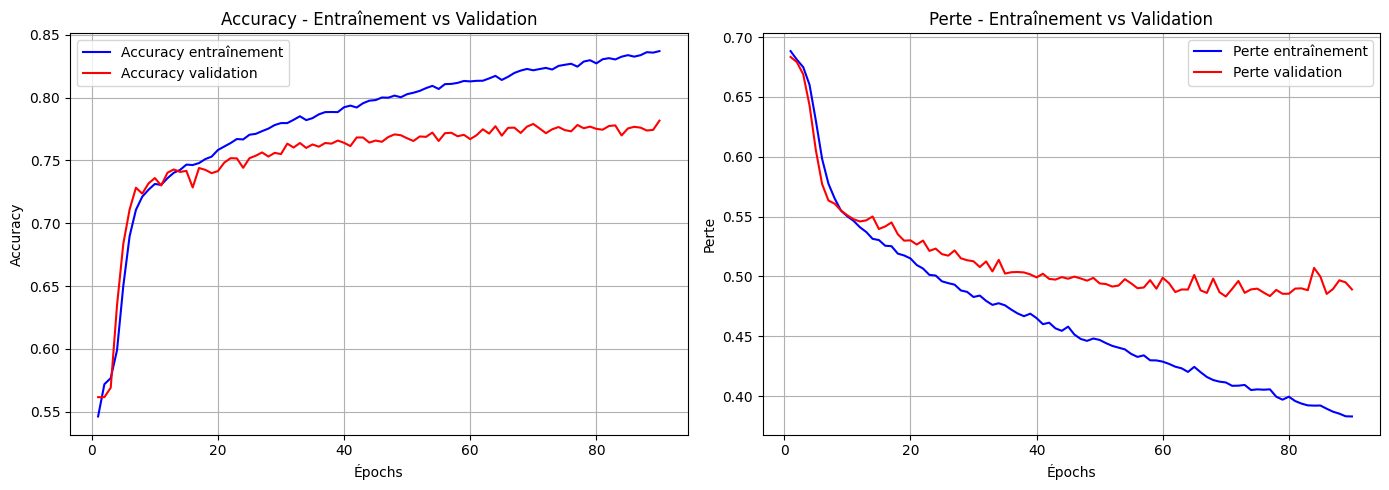

In [10]:
plot_training_history(history_tcn)

192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
Accuracy: 0.7790
Precision: 0.7310
Recall: 0.7846
F1-Score: 0.7569
AUROC: 0.8496


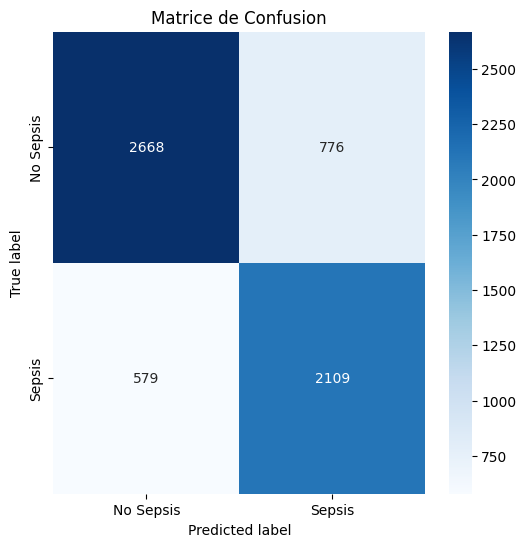

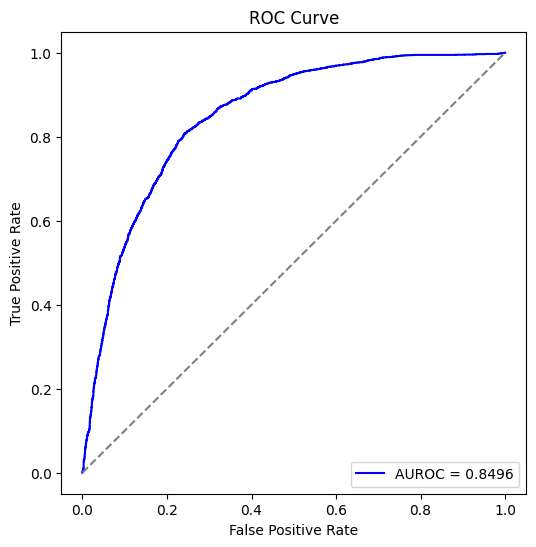

In [11]:
# Évaluer les performances du modèle sur les données de test
predict_prob, predict = evaluate_model_performance(model_tcn, normalize_sequences_test, labels_test)